In [7]:
import numpy as np
import pandas as pd
import gc
from multiprocessing import Pool
import cmasher as cmr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=Warning) 
import matplotlib.colors as colors


from os import path

import yt
from yt import YTArray

import numpy as np
from yt.units import G
import array
import pandas as pd


In [8]:
path_csv = "/mnt/usb-TOSHIBA_EXTERNAL_USB_20220124010088F-0:0-part2/snapshots/"
path_datos = "/home/bego/GARROTXA_copia/datos_GARROTXA_resim/"
path_results = "/home/bego/GARROTXA/GalaDyn/results/"
path_crossmatch = "/home/bego/GARROTXA/satelites_crossmatch/"
path_figures_acceleration = "/home/bego/GARROTXA/acceleration_figures/"
path_figures = "/home/bego/GARROTXA/acceleration_figures/"
path_acceleration = "/home/bego/GARROTXA/acceleration/"
path_disk = "/home/bego/GARROTXA/disco/"

In [9]:
datos_edades = pd.read_csv(path_datos + "edades.csv", sep = ",",index_col = 0)
class Snapshot:
    def __init__(self, name):
        self.name = name
        self.path_snapshot = None
        self.lb = None
        self.center = None
        self.Rvir = None
        self.ds = None 
        self.dm = None
        self.gas = None
        self.stars = None
        self.disk = None


        def read_lb():
            self.lb = datos_edades.loc[datos_edades['Snapshot'] == self.name, 'Lookback'].iloc[0]

        def read_center_Rvir ():
            centro = np.loadtxt(path_datos +f'center_{self.name}.txt')
            center = YTArray([centro[0], centro[1], centro[2]], "cm")
        #   cx,cy,cz = center[0].in_units("cm"), center[1].in_units("cm"),  center[2].in_units("cm")
            Rvir = YTArray(centro[3], "kpc")
            self.center = center
            self.Rvir = Rvir

        def find_path_for_yt():
            # name = snapshots_analysis[i]
            if self.name < 425:
                path_snapshot = "/media/temp1/bego/GARROTXA_ART/"
            elif (self.name >= 425)&(name < 600):
                path_snapshot = "/srv/cab1/garrotxa/GARROTXA_ART/MW_003/RUN2.2/"
            elif (self.name >=600 )&(name < 800):
                path_snapshot = "/home/Garrotxa_ART/New_Run/"
            elif (self.name >= 800) & (name < 900) :
                path_snapshot = "/media/temp/bego/New_Resim/"
            elif self.name >= 900 :
                path_snapshot = "/media/temp1/GARROTXA_ART/MW_003/RUN2.2/"
            self.path_snapshot = path_snapshot
        
        print(f"Initializing snapshot {name}")
        find_path_for_yt()
        read_lb()
        print(f"Lookback time: {self.lb} Gyr")
        read_center_Rvir()
        
    def load_stars (self):
        self.stars = pd.read_csv(path_csv + f"{self.name}_stars_Rvir.csv",sep = ",")
        self.stars = cartesian_to_cylindrical(self.stars)

    def load_dm (self):
        self.dm = pd.read_csv(path_csv + f"{self.name}_dm_Rvir.csv",sep = ",")
        self.dm = cartesian_to_cylindrical(self.dm)

    def load_gas (self):
        self.gas = pd.read_csv(path_csv + f"Gas_{self.name}.csv",sep = ",")
        self.gas = cartesian_to_cylindrical(self.gas)

    def load_disk(self):
        self.disk = pd.read_csv(path_disk + f"Stars_disco_{self.name}.csv")

    def filter_disk_particles(self):
        dfA = self.stars[self.stars['ID'].isin(self.disk["ID"])]
        df = dfA[(dfA['R']< 25)].copy()
        df["Phi"] = np.mod(np.arctan2(df["Y"], df["X"]), 2*np.pi)
        df["R"] = np.sqrt(df["X"]**2 + df["Y"]**2)
        return df




In [6]:
name = 916
ac_dm= pd.read_csv(path_acceleration +f"mesh_aceleracion_dm_{name}_ytRS_40.csv", sep = ",", index_col = 0)
ac_gas= pd.read_csv(path_acceleration +f"mesh_aceleracion_gas_{name}_ytRS_40.csv", sep = ",", index_col = 0)
ac_disk= pd.read_csv(path_acceleration +f"mesh_aceleracion_stars_{name}_ytRS_40.csv", sep = ",", index_col = 0)
#ac_nodisk = 
plt.style.use('dark_background')

In [5]:
ac_dm

,X,Y,Z,R,Phi,ax,ay,az,ar,aphi
0,-39.191917,-7.676768,0.0,39.936690,3.335020,2.014051e-14,4.990190e-15,-2.519739e-17,-2.072414e-14,1.025649e-15
1,-39.191917,-6.868687,0.0,39.789260,3.315088,2.035272e-14,4.625777e-15,-8.777732e-17,-2.084570e-14,1.042908e-15
2,-39.191917,-6.060606,0.0,39.657753,3.295017,2.240444e-14,5.900969e-15,8.408242e-16,-2.304307e-14,2.407742e-15
3,-39.191917,-5.252525,0.0,39.542328,3.274820,2.083242e-14,3.848511e-15,-1.208352e-16,-2.115902e-14,1.047170e-15
4,-39.191917,-4.444445,0.0,39.443120,3.254513,2.095819e-14,3.555708e-15,-1.008168e-16,-2.122538e-14,1.171492e-15
...,...,...,...,...,...,...,...,...,...,...
7663,39.191917,4.444445,0.0,39.443120,0.112920,-2.027882e-14,-3.796519e-15,-4.698442e-16,-2.057746e-14,1.487326e-15
7664,39.191917,5.252525,0.0,39.542328,0.133227,-2.022553e-14,-4.297270e-15,-3.414609e-16,-2.061712e-14,1.572572e-15
7665,39.191917,6.060606,0.0,39.657753,0.153424,-2.006243e-14,-4.467892e-15,-3.622047e-16,-2.050957e-14,1.349414e-15
7666,39.191917,6.868687,0.0,39.789260,0.173496,-1.986623e-14,-4.816320e-15,-2.355257e-16,-2.039941e-14,1.314574e-15


In [15]:
ac_tot = ac_dm.copy()
dimensions = ["x", "y", "z", "r", "phi"]
for dim in dimensions:
    ac_tot[f"a{dim}"] = ac_disk[f"a{dim}"]  + ac_gas[f"a{dim}"]  +ac_dm[f"a{dim}"] 
print(ac_tot)

              X         Y    Z          R       Phi            ax  \
0    -39.191917 -7.676768  0.0  39.936690  3.335020  2.547707e-14   
1    -39.191917 -6.868687  0.0  39.789260  3.315088  2.565138e-14   
2    -39.191917 -6.060606  0.0  39.657753  3.295017  2.595071e-14   
3    -39.191917 -5.252525  0.0  39.542328  3.274820  2.584737e-14   
4    -39.191917 -4.444445  0.0  39.443120  3.254513  2.637808e-14   
...         ...       ...  ...        ...       ...           ...   
7663  39.191917  4.444445  0.0  39.443120  0.112920 -2.631511e-14   
7664  39.191917  5.252525  0.0  39.542328  0.133227 -2.640416e-14   
7665  39.191917  6.060606  0.0  39.657753  0.153424 -2.559919e-14   
7666  39.191917  6.868687  0.0  39.789260  0.173496 -2.566299e-14   
7667  39.191917  7.676768  0.0  39.936690  0.193427 -2.538896e-14   

                ay            az            ar          aphi  
0     5.954172e-15 -2.547682e-16 -2.614648e-14  9.458425e-16  
1     5.317632e-15 -1.652686e-16 -2.618425e-1

In [14]:
snapshots_analysis = [520,523,525, 527,530,532,535, 537,539,541,
 543, 545,547, 550, 553, 555,557, 
 560, 563, 565, 567,570,573, 575, 577, 580,
583, 585,587,590, 592,594,
 596,598,600,
 602, 604, 608, 610, 612, 614, 616, 618, 620, 622, 624, 626, 
 629, 630, 632, 634, 636, 639, 640, 642, 644, 646, 648, 650, 652, 654, 656, 658, 660, 662, 
 664, 666, 668,670, 672, 674, 676, 679, 681, 682, 684, 687, 689,
 690, 692, 694, 698, 704,  706, 708,711, 712,714, 716,
 718, 720, 722, 724, 726, 728, 731, 732, 734, 736, 739, 740, 742, 744, 746, 748, 751,752,
 755, 756, 758, 761,763, 764, 766, 768, 770, 772, 774, 776, 778, 780, 
 782, 784, 786, 788, 790, 792, 794, 797, 798, 802, 805, 806, 808, 810, 812, 814, 816,
 818, 820, 822, 824, 826, 828, 830, 832, 834, 836, 839, 840, 842, 844, 846, 848, 850,
 853, 855, 856, 858, 860, 862, 864, 867, 870,
 872, 875, 877, 879, 881, 883, 884, 888,
890, 892, 894, 898, 900, 902, 904, 907, 908, 910, 912, 915, 916, 918, 921, 922, 924, 927, 929, 
930, 932, 934, 937,
939, 941,942, 944, 946, 948, 950, 952, 954,956, 
958, 961, 963, 965, 966, 968, 970, 972, 974, 976, 979,
980, 982, 984, 989, 990, 993, 994, 996, 999]

In [15]:
rango_z=1e-14
size = 5
ancho = 40
#snapshots_analysis = [888]
for name in snapshots_analysis:
    print(name)
    ac_dm= pd.read_csv(path_acceleration +f"mesh_aceleracion_dm_{name}_ytRS_40.csv", sep = ",", index_col = 0)
    ac_gas= pd.read_csv(path_acceleration +f"mesh_aceleracion_gas_{name}_ytRS_40.csv", sep = ",", index_col = 0)
    ac_disk= pd.read_csv(path_acceleration +f"mesh_aceleracion_stars_{name}_ytRS_40.csv", sep = ",", index_col = 0)
    ac_all= pd.read_csv(path_acceleration +f"mesh_aceleracion_total_{name}_ytRS_40.csv", sep = ",", index_col = 0)
    ac_sat = pd.read_csv(path_acceleration +f"mesh_aceleracion_{name}_all_satellites_id_ytRS.csv", sep = ",", index_col = 0)
    fig, ax = plt.subplots(1, 5, sharex=False, sharey=True,figsize = (19,3))
    az = ax[0].scatter(ac_dm.X,ac_dm.Y, marker='s', c=ac_dm.az, 
                cmap= "seismic", s = size, vmin =-rango_z, vmax = rango_z)

    lb = datos_edades.loc[datos_edades['Snapshot'] == name, 'Lookback'].iloc[0]
    ax[0].set_title(f"{lb:.2f} Gyr")

    ar = ax[1].scatter(ac_gas.X,ac_gas.Y, marker='s', c=ac_gas.az, 
                cmap= "seismic", s = size, vmin =-rango_z, vmax = rango_z)

    aphi = ax[2].scatter(ac_disk.X,ac_disk.Y, marker='s', c=ac_disk.az, 
                cmap= "seismic", s = size, vmin =-rango_z, vmax = rango_z)
    asat = ax[3].scatter(ac_sat.X,ac_sat.Y, marker='s', c=ac_sat.az_core, 
                cmap= "seismic", s = size, vmin =-rango_z, vmax = rango_z)
    cbar_aphi_ax = fig.add_axes([0.91,0.1, 0.01,0.85 ])
    fig.colorbar(ar,cbar_aphi_ax )
    aphi = ax[4].scatter(ac_all.X,ac_all.Y, marker='s', c=ac_all.az ,
                cmap= "seismic", s = size, vmin =-rango_z, vmax = rango_z)

    for k in range(5):
        ax[k].set_xlabel("X [kpc]")
      #  ax[k].set_ylabel("Y [kpc]")
        ax[k].set_xlim(-ancho,ancho)
        ax[k].set_ylim(-ancho,ancho)
    ax[0].set_ylabel("Y [kpc]")

    ax[0].text(27, 33, "DM", fontsize = 11, alpha = 0.9)
    ax[1].text(27, 33, "Gas", fontsize = 11, alpha = 0.9)
    ax[2].text(25, 33, "Stars", fontsize = 11, alpha = 0.9)
    ax[3].text(27, 33, "Satellites", fontsize = 11, alpha = 0.9)
    ax[4].text(27, 33, "All", fontsize = 11, alpha = 0.9)


    plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=0.9, wspace=0.15,hspace=0.35)
  #  plt.show()
    plt.savefig(f"acceleration_figs/sum_accelerations_{name}.png",  format='png', dpi=150, bbox_inches='tight')
    plt.close()


    ac_tot = ac_dm.copy()
    dimensions = ["x", "y", "z", "r", "phi"]
    for dim in dimensions:
        ac_tot[f"a{dim}"] = ac_disk[f"a{dim}"]  + ac_gas[f"a{dim}"]  +ac_dm[f"a{dim}"]  +ac_sat[f"a{dim}_core"] 

    ac_tot.to_csv(path_acceleration + f"mesh_aceleracion_total_{name}_ytRS_40.csv", sep = ",")


520
523
525
527
530
532
535
537
539
541
543
545
547
550
553
555
557
560
563
565
567
570
573
575
577
580
583
585
587
590
592
594
596
598
600
602
604
608
610
612
614
616
618
620
622
624
626
629
630
632
634
636
639
640
642
644
646
648
650
652
654
656
658
660
662
664
666
668
670
672
674
676
679
681
682
684
687
689
690
692
694
698
704
706
708
711
712
714
716
718
720
722
724
726
728
731
732
734
736
739
740
742
744
746
748
751
752
755
756
758
761
763
764
766
768
770
772
774
776
778
780
782
784
786
788
790
792
794
797
798
802
805
806
808
810
812
814
816
818
820
822
824
826
828
830
832
834
836
839
840
842
844
846
848
850
853
855
856
858
860
862
864
867
870
872
875
877
879
881
883
884
888
890
892
894
898
900
902
904
907
908
910
912
915
916
918
921
922
924
927
929
930
932
934
937
939
941
942
944
946
948
950
952
954
956
958
961
963
965
966
968
970
972
974
976
979
980
982
984
989
990
993
994
996
999


In [11]:
ac_sat

,X,Y,Z,ax_core,ay_core,az_core,ar_core,aphi_core,ax_stream,ay_stream,az_stream,ar_stream,aphi_stream
0,-39.191917,-7.676768,0.0,3.362488e-17,3.130192e-17,3.524467e-18,-3.901478e-17,2.425468e-17,1.361189e-17,-1.600310e-18,-4.838932e-18,-1.305043e-17,-4.186992e-18
1,-39.191917,-6.868687,0.0,3.546717e-17,3.268165e-17,3.196998e-18,-4.057644e-17,2.606843e-17,1.353560e-17,-1.564618e-18,-4.839944e-18,-1.306230e-17,-3.877735e-18
2,-39.191917,-6.060606,0.0,3.750446e-17,3.411118e-17,2.845388e-18,-4.227689e-17,2.797895e-17,1.346683e-17,-1.525152e-18,-4.847770e-18,-1.307557e-17,-3.565277e-18
3,-39.191917,-5.252525,0.0,3.975724e-17,3.558304e-17,2.467392e-18,-4.413154e-17,2.998664e-17,1.340569e-17,-1.482308e-18,-4.863472e-18,-1.309000e-17,-3.249893e-18
4,-39.191917,-4.444445,0.0,4.224745e-17,3.708686e-17,2.060585e-18,-4.615734e-17,3.209022e-17,1.335235e-17,-1.436617e-18,-4.888257e-18,-1.310543e-17,-2.932011e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7663,39.191917,4.444445,0.0,-1.523630e-17,-1.012928e-17,1.156278e-17,-1.628063e-17,8.347948e-18,-7.323337e-18,6.211504e-18,1.713727e-17,-6.576786e-18,-6.997138e-18
7664,39.191917,5.252525,0.0,-1.506284e-17,-1.018586e-17,1.124073e-17,-1.628238e-17,8.094756e-18,-7.671489e-18,5.724939e-18,1.801639e-17,-6.843047e-18,-6.693234e-18
7665,39.191917,6.060606,0.0,-1.489066e-17,-1.023619e-17,1.092489e-17,-1.628007e-17,7.840319e-18,-7.984435e-18,4.776885e-18,1.857421e-17,-7.160630e-18,-5.940977e-18
7666,39.191917,6.868687,0.0,-1.471975e-17,-1.028066e-17,1.061538e-17,-1.627348e-17,7.585294e-18,-8.108538e-18,3.751744e-18,1.848900e-17,-7.339156e-18,-5.095170e-18


In [89]:
M = 1e6
G = 1.3273e11
z = 0.054
kpc_to_km= 3.086e16

In [90]:
az = M*G/((z*kpc_to_km)**2)

In [91]:
az

4.779579957345287e-14

In [65]:
Z = np.sqrt(M*G/(1e-14))

In [66]:
Z/kpc_to_km

0.0118056152553007

In [81]:
stars = pd.read_csv(path_csv + f"{name}_stars_Rvir.csv",sep = ",")

In [92]:
stars_disk= stars[(np.abs(stars["Z"])<0.1)&(stars["R"]<20)].copy()

In [93]:
np.min(stars_disk["Mass"])

1182.3613820064943

In [94]:
np.max(stars_disk["Mass"])

1100489.9715705444

In [10]:
ac_dm

,X,Y,Z,R,Phi,ax,ay,az,ar,aphi
0,-39.191917,-7.676768,0.0,39.936690,3.335020,2.012542e-14,4.812427e-15,-3.495656e-16,-2.067516e-14,8.541030e-16
1,-39.191917,-6.868687,0.0,39.789260,3.315088,2.023912e-14,4.320412e-15,-4.293166e-16,-2.068109e-14,7.617378e-16
2,-39.191917,-6.060606,0.0,39.657753,3.295017,2.040799e-14,3.830977e-15,-4.789965e-16,-2.075373e-14,6.671683e-16
3,-39.191917,-5.252525,0.0,39.542328,3.274820,2.046590e-14,3.541503e-15,-2.419276e-16,-2.075497e-14,7.915683e-16
4,-39.191917,-4.444445,0.0,39.443120,3.254513,2.057064e-14,3.271741e-15,-3.175463e-16,-2.080829e-14,9.330033e-16
...,...,...,...,...,...,...,...,...,...,...
7663,39.191917,4.444445,0.0,39.443120,0.112920,-2.041358e-14,-3.922569e-15,-3.609429e-16,-2.072557e-14,1.597388e-15
7664,39.191917,5.252525,0.0,39.542328,0.133227,-2.028273e-14,-4.122839e-15,-4.137465e-16,-2.065065e-14,1.392088e-15
7665,39.191917,6.060606,0.0,39.657753,0.153424,-2.019634e-14,-4.573197e-15,-1.405760e-16,-2.065800e-14,1.433019e-15
7666,39.191917,6.868687,0.0,39.789260,0.173496,-2.007332e-14,-4.971104e-15,-3.476921e-16,-2.063011e-14,1.431284e-15


In [26]:
name = 892
ac_dm= pd.read_csv(path_acceleration +f"mesh_aceleracion_dm_{name}_ytRS_40.csv", sep = ",", index_col = 0)
ac_dm_tidal= pd.read_csv(path_acceleration +f"mesh_aceleracion_dm_{name}_ytRS_40_prueba_tidal.csv", sep = ",", index_col = 0)

print(ac_dm_tidal)

              X         Y    Z          R       Phi            ax  \
0    -39.191917 -7.676768  0.0  39.936690  3.335020  7.328419e-15   
1    -39.191917 -6.868687  0.0  39.789260  3.315088  7.611065e-15   
2    -39.191917 -6.060606  0.0  39.657753  3.295017  7.830506e-15   
3    -39.191917 -5.252525  0.0  39.542328  3.274820  8.359596e-15   
4    -39.191917 -4.444445  0.0  39.443120  3.254513  8.128909e-15   
...         ...       ...  ...        ...       ...           ...   
7663  39.191917  4.444445  0.0  39.443120  0.112920 -3.304218e-14   
7664  39.191917  5.252525  0.0  39.542328  0.133227 -3.272638e-14   
7665  39.191917  6.060606  0.0  39.657753  0.153424 -3.259262e-14   
7666  39.191917  6.868687  0.0  39.789260  0.173496 -3.233777e-14   
7667  39.191917  7.676768  0.0  39.936690  0.193427 -3.226944e-14   

                ay            az            ar          aphi  
0     8.221353e-15 -3.509403e-15 -8.772090e-15  6.659340e-15  
1     7.731869e-15 -3.780818e-15 -8.831530e-1

In [29]:
name = 898
ac_dm= pd.read_csv(path_acceleration +f"mesh_aceleracion_dm_{name}_ytRS_40.csv", sep = ",", index_col = 0)
ac_dm_tidal= pd.read_csv(path_acceleration +f"mesh_aceleracion_dm_{name}_ytRS_40_prueba_tidal.csv", sep = ",", index_col = 0)

print(ac_dm_tidal)

              X         Y    Z          R       Phi            ax  \
0    -39.191917 -7.676768  0.0  39.936690  3.335020 -1.510501e-15   
1    -39.191917 -6.868687  0.0  39.789260  3.315088 -1.341147e-15   
2    -39.191917 -6.060606  0.0  39.657753  3.295017 -1.216257e-15   
3    -39.191917 -5.252525  0.0  39.542328  3.274820 -1.020398e-15   
4    -39.191917 -4.444445  0.0  39.443120  3.254513 -7.736201e-16   
...         ...       ...  ...        ...       ...           ...   
7663  39.191917  4.444445  0.0  39.443120  0.112920 -4.177234e-14   
7664  39.191917  5.252525  0.0  39.542328  0.133227 -4.160769e-14   
7665  39.191917  6.060606  0.0  39.657753  0.153424 -4.141134e-14   
7666  39.191917  6.868687  0.0  39.789260  0.173496 -4.122153e-14   
7667  39.191917  7.676768  0.0  39.936690  0.193427 -4.101313e-14   

                ay            az            ar          aphi  
0     1.310160e-13  1.275394e-15 -2.370202e-14  1.288630e-13  
1     1.307581e-13  1.256414e-15 -2.125133e-1

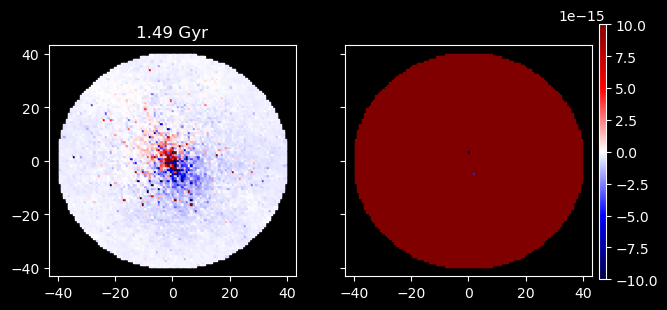

In [32]:
rango_z=1e-14
rango_z_tidal = 1e-14
size = 5
ancho = 40
name = 900
ac_dm= pd.read_csv(path_acceleration +f"mesh_aceleracion_dm_{name}_ytRS_40.csv", sep = ",", index_col = 0)
ac_dm_tidal= pd.read_csv(path_acceleration +f"mesh_aceleracion_dm_{name}_ytRS_40_prueba_tidal.csv", sep = ",", index_col = 0)

fig, ax = plt.subplots(1, 2, sharex=False, sharey=True,figsize = (7,3))

az = ax[0].scatter(ac_dm.X,ac_dm.Y, marker='s', c=ac_dm.az, 
               cmap= "seismic", s = size, vmin =-rango_z, vmax = rango_z)

lb = datos_edades.loc[datos_edades['Snapshot'] == name, 'Lookback'].iloc[0]
ax[0].set_title(f"{lb:.2f} Gyr")
az = ax[1].scatter(ac_dm_tidal.X,ac_dm_tidal.Y, marker='s', c=ac_dm_tidal.az, 
               cmap= "seismic", s = size, vmin =-rango_z_tidal, vmax = rango_z_tidal)


cbar_aphi_ax = fig.add_axes([0.91,0.1, 0.01,0.85 ])
fig.colorbar(az,cbar_aphi_ax )

#plt.savefig(f"acceleration_figs/sum_accelerations_{name}.png",  format='png', dpi=150, bbox_inches='tight')
#plt.close()


#ac_nodisk = 
plt.style.use('dark_background')